In [172]:
import sys; sys.path.append('../')
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import math
import dawdreamer
import textwrap
import librosa
import IPython.display as ipd
from src.utils import *
from src.config import daw_settings
from matplotlib.collections import LineCollection

In [171]:
# specify the target audio path
target_audio_path = '../timbre-exp/target-dataset/bill-evans-piano.wav'
print(f'Target Audio Path: {os.path.abspath(target_audio_path)}')

Target Audio Path: /Users/malek8/My Drive (malek8@mit.edu)/MIT/Spring 2023/4.453 (Creative Machine Learning for Design)/GASS Term Project/gass_repo/timbre-exp/target-dataset/bill-evans-piano.wav


In [173]:
# load the target audio with librosa
target_audio, target_sample_rate = librosa.load(target_audio_path, sr=daw_settings['SAMPLE_RATE'])

In [113]:
# specify the name of the preset used for the plot above
preset_name = 'WND Flute 1 FMR'

In [ ]:
# load the preset to the plugin from xml
df = torch.load('../dataset/processed_preset_dataset_musicnn.pt')
df.keys()

Index(['preset_names', 'parameters', 'parameters_names',
       'mapped_parameter_names', 'raw_audio', 'musicnn_features'],
      dtype='object')

In [ ]:
# find the row in df where preset_names is preset_name
preset_row = df[df['preset_names'] == preset_name]
preset_row = preset_row.reset_index(drop=True)
preset_row

,preset_names,parameters,parameters_names,mapped_parameter_names,raw_audio,musicnn_features
0,WND Flute 1 FMR,"[0.0, 0.0400000028, 0.288000017, 0.667000055, ...","[@modulation, @dcolfovalue, @dcopwmvalue, @dco...","[{'tal-uno param name': '@modulation', 'dawdre...","{'C2': [tensor(3.4535e-05), tensor(3.5455e-05)...","{'C2': [tensor(-0.0003), tensor(-0.6242), tens..."


In [ ]:
# get the parameters
preset_params = preset_row['parameters'][0]
print(preset_params)

[0.0, 0.0400000028, 0.288000017, 0.667000055, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.192000002, 0.0, 1.0, 0.380000025, 0.0560000017, 0.484000027, 1.0, 0.5, 1.0, 1.0, 0.252000004, 0.612000048, 0.508000016, 0.30400002, 0.560000002, 0.576000035, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.556000054, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19600001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.454545468, 0.5, 0.0, 0.0, 0.0, 0.0, 0.500030517578125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.800000011920929, 0.0, 0.5, 0.0, 0.300000011920929, 0.0, 0.5, 0.5, 0.2000000029802322, 0.0, 0.0, 0.1000000014901161, 0.0, 0.0]


In [2]:
# load the dataset
plot_data = torch.load('../bill-evans-parameter-objective-space-dataset.pt')

In [14]:
plot_data[0].keys()

dict_keys(['param_name', 'param_values', 'objective_function_values'])

In [154]:
plot_min = np.min([np.min(x['objective_function_values']) for x in plot_data])
plot_max = 75000
print(f'plot min: {plot_min}, plot max: {plot_max}')

plot min: 21143.986328125, plot max: 75000


In [155]:
# Create a colormap
cmap = cm.jet

# Normalize the y-values for color mapping
norm = plt.Normalize(plot_min, 
                     plot_max)

/var/folders/1h/qfss5lwn3jzdb7t8r1y63r9r0000gn/T/ipykernel_40010/2159958320.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


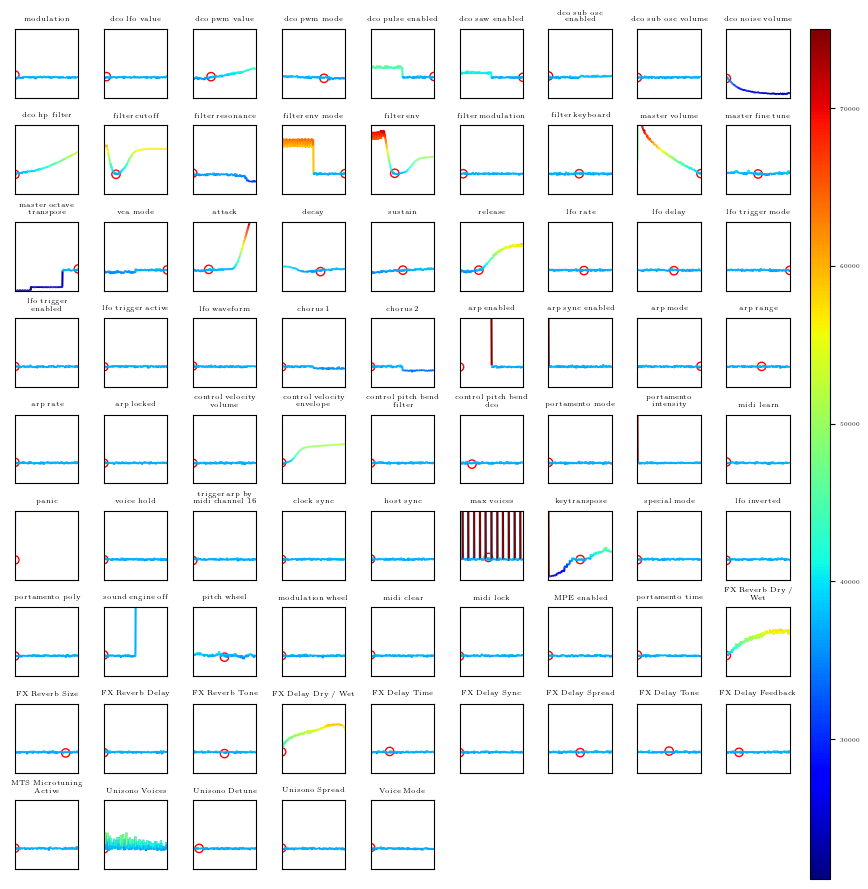

In [162]:
# set matplotlib plot settings to use latex font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 4
})

# Determine the number of rows and columns for the subplot grid
n = len(plot_data) # number of parameters
cols = math.ceil(math.sqrt(n)) # number of columns
rows = math.ceil(n / cols) # number of rows

fig = plt.figure(figsize=(10,10))

# Define the grid on which to place the subplots
grid = plt.GridSpec(rows, cols, wspace=0.4, hspace=0.4)

# Plot each parameter
for i, data in enumerate(plot_data):
    # Calculate the row and column index for the subplot
    row = i // cols
    col = i % cols

    # Create the subplot on the appropriate part of the grid
    ax = fig.add_subplot(grid[row, col])

    # Generate points for LineCollection
    points = np.array([data['param_values'], data['objective_function_values']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection
    lc = LineCollection(segments, cmap=cmap, norm=norm)

    # Set the values used for color mapping
    lc.set_array(data['objective_function_values'])

    # Add the collection to the axes
    ax.add_collection(lc)

    # get closest index to preset_params[i]
    closest_index = np.argmin((np.abs(np.array(data['param_values']) - preset_params[i])))

    # overlay a 1 point scatter plot making a red empty circle the best parameter value from preset_params
    ax.scatter(preset_params[i], data['objective_function_values'][closest_index], facecolors='none', edgecolors='red', marker='o')

    # set ylim to be between 30000 and 60000
    ax.set_ylim([plot_min, plot_max])
    ax.set_xlim([0,1])

    # Wrap the title if it is too long
    title = textwrap.fill(data['param_name'], 18)  # wraps title after 20 characters
    ax.set_title(title)

    # Hide x/y ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Create an axes for the colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.85])

# Create a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)
# Adjust the top of the figure to remove extra space
plt.subplots_adjust(top=0.95)

# Show the plot
plt.tight_layout()
plt.show()


In [163]:
# save the fig as a pdf
fig.savefig('bill-evans-parameter-objective-space.pdf', bbox_inches='tight')

In [11]:
# define the engine
engine = dawdreamer.RenderEngine(sample_rate=daw_settings['SAMPLE_RATE'], block_size=daw_settings['BLOCK_SIZE'])

In [12]:
# load the plugin
plugin = load_plugin_with_dawdreamer(daw_settings['SYNTH_PLUGIN_PATH'],daw_settings['SYNTH_NAME'],engine)

error: attempt to map invalid URI `/Library/Audio/Plug-Ins/VST3/TAL-U-NO-LX-V2.vst3'


In [26]:
# apply the preset to the plugin
loaded_preset = set_parameters(plugin, preset_params)

In [167]:
idx = [x['dawdreamer param name'] == 'filter env' for x in preset_row['mapped_parameter_names'].iloc[0]].index(True)

In [168]:
# print the mapped parameters names key
preset_row['mapped_parameter_names'].iloc[0][idx]

{'tal-uno param name': '@filterenvelopevalue',
 'dawdreamer param name': 'filter env',
 'value': 0.380000025,
 'dawdreamer index': 13,
 'tal-uno index': 13}

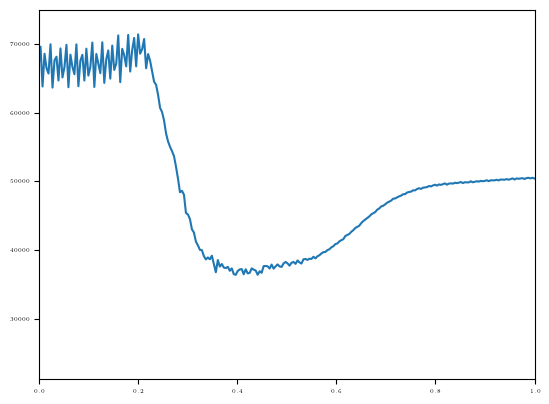

In [169]:
# plot the data from plot_data specifically at index 32
data = plot_data[idx]
obj = data['objective_function_values']
params = data['param_values']
plt.figure(2)
plt.plot(params, obj)
# set font size to be 12
plt.rcParams.update({'font.size': 14})
plt.xlim([0,1])
plt.ylim([plot_min, plot_max])
plt.show()

In [79]:
# make the 32nd index of preset_params 0.6
preset_params[32] = 0.0

In [80]:
# apply the preset to the plugin
loaded_preset = set_parameters(plugin, preset_params)

In [178]:
# render some audio
audio = render_audio(53, 127, 0.5, loaded_preset, engine, 1, daw_settings['SAMPLE_RATE'])
print(f'Audio Shape: {audio.shape}')

Audio Shape: (44100,)


In [179]:
# play the audio with ipd
ipd.Audio(audio, rate=daw_settings['SAMPLE_RATE'])

In [180]:
# play the target audio with ipd
ipd.Audio(target_audio, rate=daw_settings['SAMPLE_RATE'])

In [183]:
# compare the mean of the audio and target audio
print(f'Audio Mean: {np.mean(audio)}, {np.std(audio)}')
print(f'Target Audio Mean: {np.mean(target_audio)}, {np.std(target_audio)}')

Audio Mean: -1.0497889888938516e-05, 0.21789419651031494
Target Audio Mean: -0.001072314684279263, 0.24695007503032684
